In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In this notebook, we train a CNN to detect the configuration of piecies on a chess board. The dataset consists of 80000 400x400 images of a chess board in 28 styles and with 5-15 pieces on it from one of 32 styles. The filename decribes the layout in standard PEN notation (pieces on each row, lower case is black, upper case is white, numbers indicate a number of consecutive empty squares). We could train a CNN on the images but it is probably more efficient to train a network on individual squares/pieces.

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from glob import glob

# View the data

List of files:

In [3]:
files=glob("*.jpeg",root_dir='/kaggle/input/chess-positions/train/')

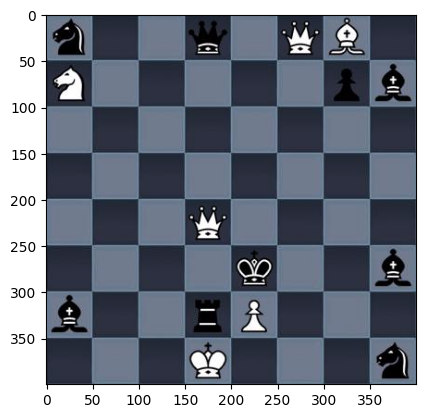

In [4]:
img=mpimg.imread('/kaggle/input/chess-positions/train/'+files[0])
plt.imshow(img);#note that the shape is 400x400x3
#print(img.dtype)

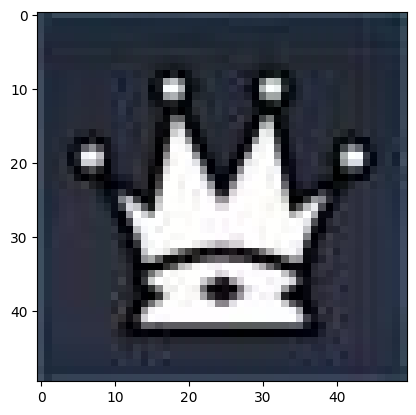

In [5]:
row=4
col=3
plt.imshow(img[row*50:(row+1)*50,col*50:(col+1)*50,:]);

# Parse the file names

In [6]:
PEN=files[0][:-5].split('-')
print(PEN)

['n2q1QB1', 'N5pb', '8', '8', '3Q4', '4k2b', 'b2rP3', '3K3n']


Let's explicitly write 0 for each empty square. This will make it easier to identifty the position of the pieces

In [7]:
d={'1':'0','2':'00','3':'000','4':'0000','5':'00000','6':'000000','7':'0000000','8':'00000000'}
trans_table=str.maketrans(d)
s=[item.translate(trans_table) for item  in PEN]
print(s)

['n00q0QB0', 'N00000pb', '00000000', '00000000', '000Q0000', '0000k00b', 'b00rP000', '000K000n']


And we invert the transformation as follows

In [8]:
s1=s
for k, v in reversed(list(d.items())):
    s1=[item.replace(v, k) for item in s1]
s1

['n2q1QB1', 'N5pb', '8', '8', '3Q4', '4k2b', 'b2rP3', '3K3n']

We map pieces to ints by

In [9]:
map_to_ints={'n':0,'N':1,'b':2,'B':3,'r':4,'R':5,'p':6,'P':7,'k':8,'K':9,'q':10,'Q':11,'0':12}
labels=[map_to_ints[char] for char in s[0]]
labels

[0, 12, 12, 10, 12, 11, 3, 12]

Define the reverse map from ints to characters

In [10]:

map_from_ints=dict((v, k) for k, v in map_to_ints.items())
x=[map_from_ints[k] for k in labels]
print(x)

['n', '0', '0', 'q', '0', 'Q', 'B', '0']


# Define a model for classifying individual squares

We use the a similar toplogy to the MNIST digits problem i.e. 2 convolutional layers and 2 fully connected layers

In [32]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

      # First 2D convolutional layer. Takes in the 3x50x50 images
      # outputting 32 convolutional features, with a square kernel size of 5
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv1_bn=nn.BatchNorm2d(32)
        
      # Second 2D convolutional layer, taking in the 32 input layers,
      # outputting 64 convolutional features, with a square kernel size of 5
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv2_bn=nn.BatchNorm2d(64)

      # Designed to ensure that adjacent pixels are either all 0s or all active
      # with an input probability
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout(0.5)

      # First fully connected layer
        self.fc1 = nn.Linear(5184, 128)
      # Second fully connected layer that outputs our 13 labels
        self.fc2 = nn.Linear(128, 13)
    
    def forward(self, x):

        x = self.conv1(x)               #Nx3x50x50 -> Nx32x46x46
        x = self.conv1_bn(x)
        x = F.relu(x) 
        x = F.max_pool2d(x, 2)            ##Nx32x46x46 -> Nx32x23x23

        x = self.conv2(x)               #Nx32x23x23 -> Nx64x19x19
        x = self.conv2_bn(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)            ##Nx64x19x19 -> Nx64x9x9
        
      # Pass data through dropout1
        x = self.dropout1(x)
      # Flatten x with start_dim=1
        x = torch.flatten(x, 1)
      # Pass data through ``fc1``
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

      # Apply softmax to x
      #output = F.log_softmax(x, dim=1)# nn.CrossEntropyLoss() takes in logits
        return x#output

my_nn = Net()
print(my_nn)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=5184, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=13, bias=True)
)


Test the model first

In [33]:
input=torch.tensor(img[0:50,0:50,:].transpose(2,0,1),dtype=torch.float32)/255# convert to tensor of floats
input=torch.unsqueeze(input,0)#batch dimension
print(input.shape)
result = my_nn(input)
print(result)

torch.Size([1, 3, 50, 50])
tensor([[-1.0068,  0.5435, -0.6878, -0.4854,  0.4951,  0.6173, -0.7435, -0.3311,
          0.6586,  0.4517,  0.0605,  0.0138,  0.4469]],
       grad_fn=<AddmmBackward0>)


Set the optimizer

In [34]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_nn.parameters(), lr=0.001, momentum=0.9)

# Train the model

In [35]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
my_nn.to(device)

cuda:0


Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=5184, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=13, bias=True)
)

In [44]:
accuracy_train=np.zeros(0,)
loss_train=np.zeros(0,)

In [ ]:
n_epochs=31

In [55]:
map_to_ints={'n':0,'N':1,'b':2,'B':3,'r':4,'R':5,'p':6,'P':7,'k':8,'K':9,'q':10,'Q':11,'0':12}

N_samples=5000

x_train=np.ndarray((64,3,50,50),np.uint8)
y_train=np.ndarray((64,),np.uint8)

all_predictions=np.ndarray((N_samples*64,),dtype='int64')
all_labels=np.ndarray((N_samples*64,),dtype='int64')

while loss_train.shape[0]<n_epochs:
#for epoch in range(n_epochs):  # loop over the dataset multiple times
    epoch=loss_train.shape[0]+1
    my_nn.train()
    running_loss = 0.0
    num_list = random.sample(range(0, N_samples), N_samples)
    for i in range(0,N_samples):
        k=num_list[i]
        img=mpimg.imread('/kaggle/input/chess-positions/train/'+files[k])
        
        s=files[k][:-5].replace('-','').translate(trans_table)
        y_train=[map_to_ints[x] for x in s]
        
        j=0
        for row in range(8):
            for col in range(8):
                x_train[j,:,:,:]=img[row*50:(row+1)*50,col*50:(col+1)*50,:].transpose(2,0,1)
                j+=1
                
        batch=torch.tensor(x_train,dtype=torch.float32).to(device)/255
        labels=torch.tensor(y_train,dtype=torch.long).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = my_nn(batch)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        # print statistics
        running_loss += loss.item()
        
        if i% 1000 == 0:
            print(f'[{epoch}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            

#after each epoch, run again on the training data
    with torch.no_grad():
        my_nn.eval()
        loss=0
        for i in range(0,N_samples):
            img=mpimg.imread('/kaggle/input/chess-positions/train/'+files[i])
        
            s=files[i][:-5].replace('-','').translate(trans_table)
            y_train=[map_to_ints[x] for x in s]
            all_labels[64*i:(64*(i+1))]=y_train
        
            j=0
            for row in range(8):
                for col in range(8):
                    x_train[j,:,:,:]=img[row*50:(row+1)*50,col*50:(col+1)*50,:].transpose(2,0,1)
                    j+=1
                
            batch=torch.tensor(x_train,dtype=torch.float32).to(device)/255
            labels=torch.tensor(y_train,dtype=torch.long).to(device)

            outputs = my_nn(batch)
            loss += criterion(outputs, labels).item()
            _, batch_predictions = torch.max(outputs.data, 1)
            all_predictions[64*i:(64*(i+1))]=batch_predictions.cpu().numpy()
            
        
        accuracy_train=np.append(accuracy_train,sum(all_labels==all_predictions)/all_labels.shape[0])
        loss_train=np.append(loss_train,loss)
        

    
    print(f'[{epoch}, {i + 1:5d}] training loss: {loss_train[epoch-1]}, training accuracy: {accuracy_train[epoch-1]}')

print('Finished Training')

[31,  5000] training loss: 69.84791037068058, training accuracy: 1.0
Finished Training


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

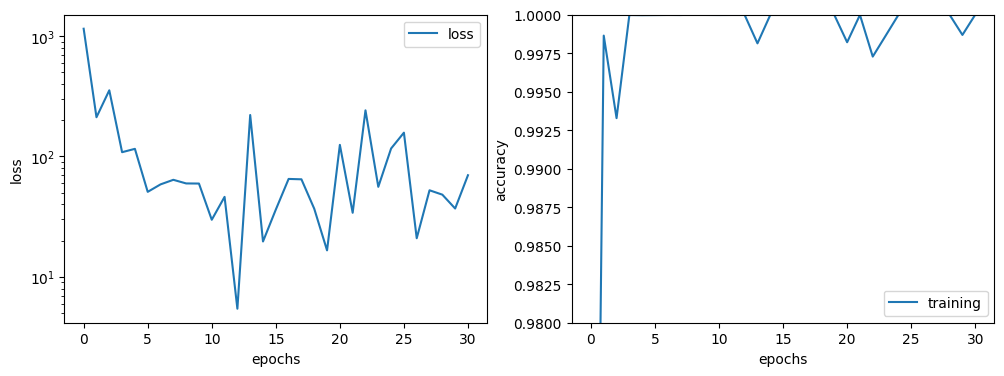

In [48]:
import seaborn as sns
fig,ax=plt.subplots(1,2,figsize=(12,4))

sns.lineplot(pd.DataFrame({'loss':loss_train },index=range(n_epochs)),ax=ax[0]);
ax[0].set_yscale('log')
ax[0].set_ylabel('loss');
ax[0].set_xlabel('epochs');

sns.lineplot(pd.DataFrame({'training':accuracy_train },index=range(n_epochs)),ax=ax[1]);
ax[1].set_ylim(0.98,1);
ax[1].set_ylabel('accuracy');
ax[1].set_xlabel('epochs');

In [49]:
#save the model
PATH = '/kaggle/working/my_nn.pth'
torch.save(my_nn.state_dict(), PATH)

In [ ]:
#load the model
PATH = '/kaggle/working/my_nn.pth'
my_nn = Net()
my_nn.load_state_dict(torch.load(PATH))

# Run the model on the test data

Let's rerun on the test data

In [41]:
test_files=glob("*.jpeg",root_dir='/kaggle/input/chess-positions/test/')

In [50]:
x_test=np.ndarray((64,3,50,50),np.uint8)

N_test=3000 # first N_test images

results=np.ndarray((N_test,),np.bool_)

my_nn.eval()
with torch.no_grad():

    for j in range(N_test):
        file=test_files[j]
        img=mpimg.imread('/kaggle/input/chess-positions/test/'+file)
        i=0
        for row in range(8):
            for col in range(8):
                x_test[i,:,:,:]=img[row*50:(row+1)*50,col*50:(col+1)*50,:].transpose(2,0,1)
                i+=1
        batch=torch.tensor(x_test,dtype=torch.float32).to(device)/255
        outputs = my_nn(batch)
        _, batch_predictions = torch.max(outputs.data, 1)
        p=[map_from_ints[k] for k in batch_predictions.cpu().numpy()]
        s=[''.join(p[:8]),''.join(p[8:16]),''.join(p[16:24]),''.join(p[24:32]),''.join(p[32:40]),''.join(p[40:48]),''.join(p[48:56]),''.join(p[56:64])]        
        PEN='-'.join(s)
        for k, v in reversed(list(d.items())):
            PEN=PEN.replace(v, k)
        results[j]=file[:-5]==PEN
        if results[j]==False:
             print(file[:-5],PEN)

In [51]:
sum(results)/len(results)

1.0

Note that very high square accuracy is needed to obtain high board accuracy e.g. 0.9999^64=0.993.

****Important lesson****

Since most of the chess board is empty, the empty squares dominate the dataset. One may think that it would be better to choose a balanced dataset on which to train. However, while this still leads to high test (and validation) accuracy on individual squares (as obtained here), the test acurracy is worse than expected (e.g. 90% rather than 98%). On inspection, the majority of the errors are due the mis-classification of empty squares and, in particular, empty squares that have high variance due to a non-uniform board pattern. Therefore it appears that the model has not seen sufficient empty squares to obtain the high test accuracy required. Since the test data is inherently unbalanced, it is makes sense to also train on the entire boards as we have done here. Then the obtained test accuracy on boards is consistent with the prediction test_accuracy**64. In the above batch normalisation allowed use to achieve training accuracy of 100%